In [16]:
import os
import random
import torch

context_weights = {
        "morning": {"pressure": 0.3, "avg_speed": 0.4, "queue": -0.3, "diff_wait_time": 0.2},
        "midday": {"pressure": 0.2, "avg_speed": 0.5, "queue": -0.1, "diff_wait_time": 0.1},
        "evening": {"pressure": 0.2, "avg_speed": 0.3, "queue": -0.3, "diff_wait_time": 0.2},
        "night": {"pressure": 0.1, "avg_speed": 0.6, "queue": -0.1, "diff_wait_time": 0.1},
        "rainy": {"pressure": 0.4, "avg_speed": 0.3, "queue": -0.2, "diff_wait_time": 0.1},
        "warm": {"pressure": 0.2, "avg_speed": 0.4, "queue": -0.2, "diff_wait_time": 0.2},
        "windy": {"pressure": 0.3, "avg_speed": 0.3, "queue": -0.3, "diff_wait_time": 0.1},
        "hew": {"pressure": 0.4, "avg_speed": 0.2, "queue": -0.2, "diff_wait_time": 0.1},
        "holiday": {"pressure": 0.1, "avg_speed": 0.5, "queue": -0.3, "diff_wait_time": 0.1},
        "workday": {"pressure": 0.2, "avg_speed": 0.3, "queue": -0.3, "diff_wait_time": 0.2},
    }

base_flow = {
    # Time-based contexts
    "morning": {"vehsPerHour": 600, "adjustment": 1.0},  # Morning has high traffic
    "midday": {"vehsPerHour": 400, "adjustment": 0.8},   # Midday has moderate traffic
    "evening": {"vehsPerHour": 700, "adjustment": 1.1},  # Evening has the highest traffic
    "night": {"vehsPerHour": 200, "adjustment": 0.5},    # Night has low traffic

    # Weather-based contexts
    "rainy": {"adjustment": 0.8},                       # Traffic flow decreases in rain
    "warm": {"adjustment": 1.05},                        # Normal traffic flow in warm weather
    "windy": {"adjustment": 0.7},                       # Slightly reduced flow in windy weather
    "hew": {"adjustment": 0.6},                         # Reduced flow in hew (humid and windy)

    # Day-based contexts
    "holiday": {"adjustment": 0.6},                     # Traffic significantly reduces on holidays
    "workday": {"adjustment": 1.4},                     # Higher traffic on workdays
}

class Context:
    def __init__(self, context_name, rou_path, alpha=0.1, reset=False):
        """
        Initialize a context with its name and rou.xml path.

        Args:
            context_name (str or list of str): The name(s) of the context (e.g., 'morning', 'rainy').
            rou_path (str): Path to the generated .rou.xml file.
            alpha (float): Degree of randomness for route generation.
        """
        self.name = context_name if isinstance(context_name, list) else [context_name]
        self.rou_path = rou_path
        self.alpha = alpha

        if (not os.path.exists(self.rou_path)) or reset:
            print(f"File {self.rou_path} not found. Generating...")
            self.generate_rou_file(self.name, self.rou_path, alpha=self.alpha)

    def reward_weights(self):
        """
        Outputs the weights for the reward function based on the context.

        Returns:
            dict: Averaged weights for the given context(s).
        """

        # Default weights for unknown contexts
        default_weights = {"pressure": 0, "avg_speed": 0, "queue": 0, "diff_wait_time": 1}

        # Calculate averaged weights for multiple contexts
        combined_weights = default_weights.copy()
        for ctx in self.name:
            weights = context_weights.get(ctx, default_weights)
            for key in combined_weights:
                combined_weights[key] += weights[key]

        # Average weights over the number of contexts
        num_contexts = len(self.name)
        averaged_weights = {key: value / num_contexts for key, value in combined_weights.items()}
        return averaged_weights
    
    def as_tensor(self, device='cpu'):
        return torch.tensor([*list(self.reward_weights().values()), self.get_flow_rate(self.name)]).view(1, -1).to(device)
    
    @staticmethod
    def get_flow_rate(ctx):
        if isinstance(ctx, list):
            vehs_per_hour = 400
            adjustment = 1
            for c in ctx:
                if c in base_flow:
                    vehs_per_hour = max(base_flow[c].get("vehsPerHour", 400), vehs_per_hour)
                    adjustment = min(base_flow[c].get("adjustment", 1.0), adjustment)
        elif ctx in base_flow:
            vehs_per_hour = base_flow[ctx].get("vehsPerHour", 400)
            adjustment = base_flow[ctx].get("adjustment", 1.0)

        return int(vehs_per_hour * adjustment)
    
    @staticmethod
    def generate_rou_file(ctx, output_path="context_rou.xml", alpha=0.05):
        """
        Generates a .rou.xml file with flows across all available routes, introducing randomness.

        Args:
            context (str or list of str): Context(s) like 'rainy', 'morning', 'workday'.
            output_path (str): Path to save the generated .rou.xml file.
            alpha (float): Degree of randomness (0 for no randomness, up to 1 for high randomness).

        Returns:
            str: Path to the generated .rou.xml file.
        """
        # Base routes for 2 way single intersection
        routes = [
            {"id": "route_ns", "edges": "n_t t_s"},
            {"id": "route_nw", "edges": "n_t t_w"},
            {"id": "route_ne", "edges": "n_t t_e"},
            {"id": "route_we", "edges": "w_t t_e"},
            {"id": "route_wn", "edges": "w_t t_n"},
            {"id": "route_ws", "edges": "w_t t_s"},
            {"id": "route_ew", "edges": "e_t t_w"},
            {"id": "route_en", "edges": "e_t t_n"},
            {"id": "route_es", "edges": "e_t t_s"},
            {"id": "route_sn", "edges": "s_t t_n"},
            {"id": "route_se", "edges": "s_t t_e"},
            {"id": "route_sw", "edges": "s_t t_w"},
        ]

        # Default settings
        start = 0
        end = 3600

        base_flow_rate = Context.get_flow_rate(ctx)

        with open(output_path, "w") as file:
            file.write("<routes>\n")

            # Adding routes
            for route in routes:
                file.write(f'    <route id="{route["id"]}" edges="{route["edges"]}"/>\n')

            # Adding flows with randomness
            for route in routes:
                random_factor = 1 + random.uniform(-alpha, alpha)  # Scaling by (1 ± alpha)
                flow_rate = int(base_flow_rate * random_factor)
                file.write(
                    f'    <flow id="flow_{route["id"]}" route="{route["id"]}" '
                    f'begin="{start}" end="{end}" vehsPerHour="{flow_rate}" '
                    f'departSpeed="max" departLane="best"/>\n'
                )

            file.write("</routes>\n")

        return output_path

In [17]:
from sumo_rl import SumoEnvironment

class SUMOContextualEnv(SumoEnvironment):
    def reset_context(self, context:Context):
        self.context = context
        self.change_reward_weight(**context.reward_weights())
        
    def change_reward_weight(self, **kwargs):
        self.pressure_weight = kwargs.get('pressure', 0)
        self.avg_speed_weight = kwargs.get('avg_speed', 0)
        self.diff_wait_weight = kwargs.get('diff_wait_time', 1)
        self.total_queue_weight = kwargs.get('queue', -1)

    def _compute_rewards(self):
        self.rewards.update(
            {
                ts: self._process_ts_reward(ts)
                for ts in self.ts_ids
                if self.traffic_signals[ts].time_to_act or self.fixed_ts
            }
        )
        return {ts: self.rewards[ts] for ts in self.rewards.keys() if self.traffic_signals[ts].time_to_act or self.fixed_ts}
    
    def _process_ts_reward(self, ts):
        reward = self.pressure_weight * self.traffic_signals[ts].get_pressure()
        reward += self.avg_speed_weight * self.traffic_signals[ts].get_average_speed()
        reward += self.total_queue_weight * self.traffic_signals[ts].get_total_queued()
        if self.diff_wait_weight != 0:
            ts_wait = sum(self.traffic_signals[ts].get_accumulated_waiting_time_per_lane()) / 100.0
            reward += self.diff_wait_weight * (self.traffic_signals[ts].last_measure - ts_wait)
            self.traffic_signals[ts].last_measure = ts_wait
        reward = reward / 100
        self.traffic_signals[ts].last_reward = reward
        return reward
    
base_path = './nets/2way-single-intersection/single-intersection'
def make_context_env(ctx, reset=False):
    ctx_name = '_'.join(ctx)
    context = Context(ctx_name, f'{base_path}-{ctx_name}.rou.xml', reset=reset)
    sumo_env = SUMOContextualEnv(
        net_file=base_path+'.net.xml',
        route_file=context.rou_path,
        out_csv_name=f'./outputs/{ctx_name}/out', 
        single_agent = True,
        use_gui=False,
        num_seconds=1000
    )
    sumo_env.reset_context(context)
    return context, sumo_env

In [18]:
import torch
from stable_baselines3 import DQN

def eval_DQN(sumo_env, model,  max_iter = 1000):
    obs, info = sumo_env.reset()
    total_reward = 0
    info_dump = []
    for _ in range(max_iter):
        with torch.no_grad():
            action, meta = model.predict(obs)
        obs, reward, done, trunc, info = sumo_env.step(action)
        total_reward += reward
        info['reward'] = reward
        info_dump.append(info)
        if done:
            break
    return total_reward, info_dump

def train_DQN(ctx, reset=False):
    context, sumo_env = make_context_env(ctx, reset=reset)
    sumo_env.reset()
    if reset or (not os.path.exists(f'./experts/dqn{context.name}.pth')):
        model = DQN(
            env=sumo_env,
            policy="MlpPolicy",
            learning_rate=1e-3,
            learning_starts=0,
            train_freq=1,
            target_update_interval=500,
            exploration_initial_eps=0.05,
            exploration_final_eps=0.01,
            verbose=1,
            device = torch.device('mps')
        )
        model.learn(total_timesteps=10000)
        model.save(f'./experts/dqn{context.name}.pth')
    else:
        model = DQN.load(f'./experts/dqn{context.name}.pth')
    return model, sumo_env

In [19]:
model_morning, env_morning = train_DQN(['morning'], reset=False)

 Retrying in 1 seconds
Step #0.00 (0ms ?*RT. ?UPS, TraCI: 10ms, vehicles TOT 0 ACT 0 BUF 0)                     
 Retrying in 1 seconds


In [20]:
model_midday, env_midday = train_DQN(['midday'], reset=False)

 Retrying in 1 seconds
Step #0.00 (0ms ?*RT. ?UPS, TraCI: 8ms, vehicles TOT 0 ACT 0 BUF 0)                      
 Retrying in 1 seconds


In [21]:
model_evening, env_evening = train_DQN(['evening'], reset=False)

 Retrying in 1 seconds
Step #0.00 (0ms ?*RT. ?UPS, TraCI: 11ms, vehicles TOT 0 ACT 0 BUF 0)                     
 Retrying in 1 seconds


In [22]:
model_night, env_night = train_DQN(['night'], reset=False)

 Retrying in 1 seconds
Step #0.00 (0ms ?*RT. ?UPS, TraCI: 7ms, vehicles TOT 0 ACT 0 BUF 0)                      
 Retrying in 1 seconds


In [23]:
model_ewr, env_ewr = train_DQN(['evening', 'workday', 'rainy'], reset=True)

File ./nets/2way-single-intersection/single-intersection-evening_workday_rainy.rou.xml not found. Generating...
 Retrying in 1 seconds
Step #0.00 (0ms ?*RT. ?UPS, TraCI: 9ms, vehicles TOT 0 ACT 0 BUF 0)                      
 Retrying in 1 seconds
Using mps device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Step #0.00 (0ms ?*RT. ?UPS, TraCI: 103ms, vehicles TOT 0 ACT 0 BUF 0)                    
 Retrying in 1 seconds
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 33ms, vehicles TOT 935 ACT 120 BUF 415)              
 Retrying in 1 seconds
Step #1000.00 (1ms ~= 1000.00*RT, ~121000.00UPS, TraCI: 35ms, vehicles TOT 828 ACT 121 BUF 
 Retrying in 1 seconds
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 42ms, vehicles TOT 894 ACT 141 BUF 456)              
 Retrying in 1 seconds
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 41ms, vehicles TOT 864 ACT 140 BUF 486)              
 Retrying in 1 seconds
----------------------------------
| rollout/            |          |
|    ep_len_mea

In [9]:
all_rew_table = []
for mdl in {model_morning, model_midday, model_evening, model_night}:
    mdl_table = []
    for senv in [env_morning, env_midday, env_evening, env_night]:
        rew, _ = eval_DQN(senv, mdl)
        mdl_table.append(rew)
    all_rew_table.append(mdl_table)

Step #0.00 (0ms ?*RT. ?UPS, TraCI: 37104ms, vehicles TOT 0 ACT 0 BUF 0)                  
 Retrying in 1 seconds
Step #0.00 (0ms ?*RT. ?UPS, TraCI: 51135ms, vehicles TOT 0 ACT 0 BUF 0)                  
 Retrying in 1 seconds
Step #0.00 (0ms ?*RT. ?UPS, TraCI: 76519ms, vehicles TOT 0 ACT 0 BUF 0)                  
 Retrying in 1 seconds
Step #0.00 (0ms ?*RT. ?UPS, TraCI: 118053ms, vehicles TOT 0 ACT 0 BUF 0)                 
 Retrying in 1 seconds
Step #5000.00 (1ms ~= 1000.00*RT, ~92000.00UPS, TraCI: 80907ms, vehicles TOT 3988 ACT 92 B
 Retrying in 1 seconds
Step #5000.00 (0ms ?*RT. ?UPS, TraCI: 98105ms, vehicles TOT 3852 ACT 6 BUF 0)             
 Retrying in 1 seconds
Step #5000.00 (0ms ?*RT. ?UPS, TraCI: 83311ms, vehicles TOT 4082 ACT 115 BUF 4233)        
 Retrying in 1 seconds
Step #5000.00 (0ms ?*RT. ?UPS, TraCI: 117743ms, vehicles TOT 2434 ACT 0 BUF 0)            
 Retrying in 1 seconds
Step #5000.00 (0ms ?*RT. ?UPS, TraCI: 95804ms, vehicles TOT 4350 ACT 127 BUF 2930)        
 

In [49]:

nn_rew = []
for i, nnl in enumerate(all_rew_table):
    nn_rew.append(nnl[i])
all_rew_table.append(nn_rew)

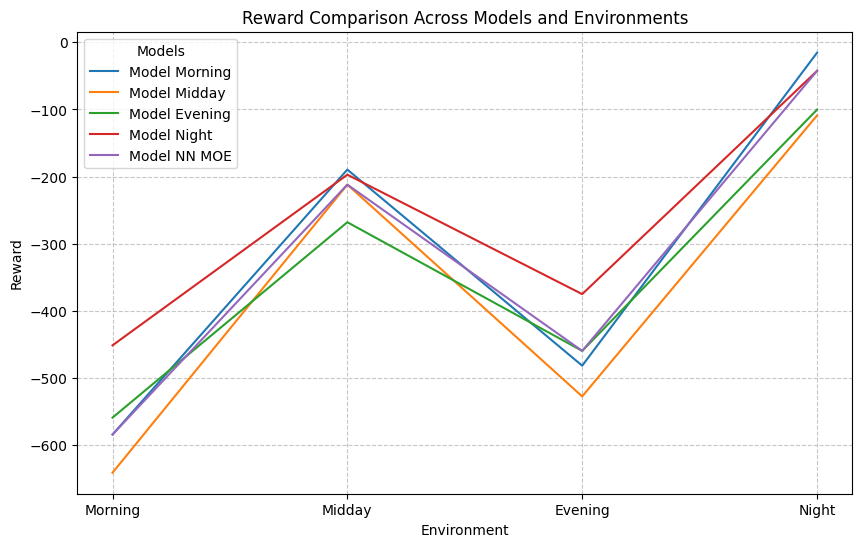

In [ ]:
from matplotlib import pyplot as plt
environments = ["Morning", "Midday", "Evening", "Night", "NN MOE"]
envx = ["Morning", "Midday", "Evening", "Night"]

# Plotting the rewards
plt.figure(figsize=(10, 6))

for i, model_rewards in enumerate(all_rew_table):
    plt.plot(envx, model_rewards, label=f"Model {environments[i]}")

plt.title("Reward Comparison Across Models and Environments")
plt.xlabel("Environment")
plt.ylabel("Total Reward")
plt.legend(title="Models")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [12]:
from torch import nn
import torch.nn.functional as F

In [25]:
class NNMOE:
    def __init__(self, experts_context, device=torch.device('cpu')):
        super().__init__()
        self.experts_ctx = experts_context
        self.device = device

    def __call__(self, context:Context):
        """_summary_

        Args:
            context (_type_): _description_
            obs (_type_): _description_

        Returns:
            _type_: _description_
        """
        ctx = context.as_tensor(device=self.device)
        sim = []
        for ectx in self.experts_ctx:
            tectx = ectx.as_tensor(device=self.device)
            sim.append((tectx * ctx).sum())

        return torch.tensor(sim).argmax().item()

In [26]:
nnmoe = NNMOE([env_morning.context, env_midday.context, env_evening.context, env_night.context])

In [29]:
nnmoe(env_ewr.context)

2

In [30]:
_, info_ewr= eval_DQN(env_ewr, model_ewr)
_, info_nn = eval_DQN(env_ewr, model_evening)

Step #0.00 (0ms ?*RT. ?UPS, TraCI: 667609ms, vehicles TOT 0 ACT 0 BUF 0)                 
 Retrying in 1 seconds
Step #5000.00 (0ms ?*RT. ?UPS, TraCI: 33ms, vehicles TOT 3438 ACT 95 BUF 1410)            
 Retrying in 1 seconds


In [46]:
_, info_ng = eval_DQN(env_ewr, model_night)
_, info_nm = eval_DQN(env_ewr, model_morning)
_, info_nd = eval_DQN(env_ewr, model_midday)

Step #5000.00 (0ms ?*RT. ?UPS, TraCI: 863439ms, vehicles TOT 4025 ACT 108 BUF 823)        
 Retrying in 1 seconds
Step #5000.00 (0ms ?*RT. ?UPS, TraCI: 11ms, vehicles TOT 4057 ACT 36 BUF 791)             
 Retrying in 1 seconds
Step #5000.00 (1ms ~= 1000.00*RT, ~68000.00UPS, TraCI: 21ms, vehicles TOT 4375 ACT 68 BUF 
 Retrying in 1 seconds


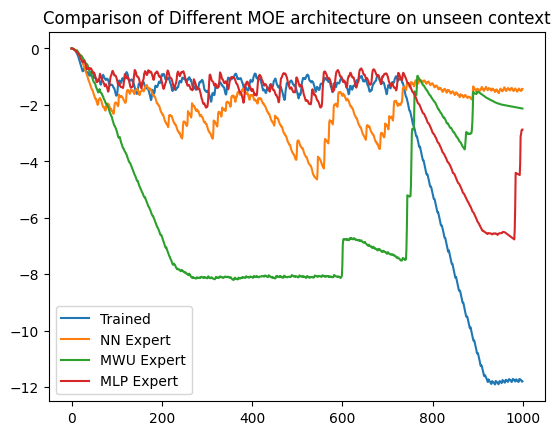

In [81]:
k = 1
plt.plot(torch.arange(0, 1000, k),
    torch.tensor([i['reward'] for i in info_ewr]).view(-1, k).sum(dim=-1).cumsum(dim=0), label='Trained')
plt.plot(torch.arange(0, 1000, k),
    torch.tensor([i['reward'] for i in info_nn]).view(-1, k).sum(dim=-1).cumsum(dim=0), label='NN Expert')
plt.plot(torch.arange(0, 1000, k),
    torch.tensor([i['reward'] for i in info_ng]).view(-1, k).sum(dim=-1).cumsum(dim=0), label='MWU Expert')
plt.plot(torch.arange(0, 1000, k),
    # torch.tensor([i['reward'] for i in info_nm]).view(-1, k).sum(dim=-1).cumsum(dim=0), label='NN Expert2')
# plt.plot(torch.arange(0, 1000, k),
    torch.tensor([i['reward'] for i in info_nd]).view(-1, k).sum(dim=-1).cumsum(dim=0), label='MLP Expert')
plt.title('Comparison of Different MOE architecture on unseen context')
plt.legend()
plt.show()

In [76]:
wmoe(env_night.context)

tensor([[1.1170e-19, 1.0000e+00, 3.7079e-19, 1.8067e-18]], device='mps:0',
       grad_fn=<SoftmaxBackward0>)

In [79]:
random.choice([1, 2, 3, 4])

3

In [ ]:
class WeightedMOE(nn.Module):
    def __init__(self, context_size,  num_expert, device=torch.device('cpu')):
        super().__init__()
        self.gating_network = nn.Sequential(
            nn.Linear(context_size, 128),
            nn.ReLU(),
            nn.Linear(128, num_expert)
        ).to(device)
        self.device = device

    def forward(self, context:Context):
        """_summary_

        Args:
            context (_type_): _description_
            obs (_type_): _description_

        Returns:
            _type_: _description_
        """
        ctx = context.as_tensor(device=self.device)
        return F.softmax(self.gating_network(ctx), dim=-1)
    
    
    
experts = [model_morning, model_midday, model_evening, model_night]
class MOEasMOdel:
    def __init__(self, moe, context, obs_mixing=False):
        self.moe = moe
        self.context = context
        self.obs_mixing = obs_mixing

    def predict(self, obs):
        context = (self.context, obs) if self.obs_mixing else (self.context,)
        exp_idx = self.moe(*context).argmax().item()
        return experts[exp_idx].predict(obs)

In [62]:
wmoe = WeightedMOE(5, 4, 'mps')
optim = torch.optim.Adam(wmoe.parameters())

In [63]:
mor = [i['reward'] for i in info_nm]
md = [i['reward'] for i in info_nd]
mor2 = [i['reward'] for i in info_nn]
mor3 = [i['reward'] for i in info_ng]
for _ in range(25):
    m, d, e, n = 0, 0, 0, 0
    for i in range(1000):
        out = wmoe(env_ewr.context)
        m += mor[i]
        d += md[i]
        e += mor2[i]
        n += mor3[i]
        tr = torch.tensor([[m, d, e, n]]).to('mps').to(torch.float32)
        tr = tr / (tr.sum() + 1e-6)
        # print(out, tr)
        loss = nn.CrossEntropyLoss()(out, tr)
        optim.zero_grad()
        loss.backward()
        optim.step()
        print(f'loss {loss.item()}')

loss -0.0
loss -0.0
loss 1.5535619258880615
loss 1.4580037593841553
loss 1.417741298675537
loss 1.4183040857315063
loss 1.422298789024353
loss 1.453479290008545
loss 1.5015215873718262
loss 1.522200584411621
loss 1.5128639936447144
loss 1.4952166080474854
loss 1.4771794080734253
loss 1.4956817626953125
loss 1.5018227100372314
loss 1.5020912885665894
loss 1.5066161155700684
loss 1.5191220045089722
loss 1.5166646242141724
loss 1.5007449388504028
loss 1.4867805242538452
loss 1.4891233444213867
loss 1.4934463500976562
loss 1.5074036121368408
loss 1.4969710111618042
loss 1.5099997520446777
loss 1.526517629623413
loss 1.5426732301712036
loss 1.5483640432357788
loss 1.5431833267211914
loss 1.5374815464019775
loss 1.5270284414291382
loss 1.510528326034546
loss 1.4981070756912231
loss 1.4923573732376099
loss 1.4991469383239746
loss 1.5120857954025269
loss 1.522430419921875
loss 1.537644863128662
loss 1.5377614498138428
loss 1.54665207862854
loss 1.5578899383544922
loss 1.565490484237671
loss 1.

In [29]:
context_morning = Context('morning', base_path+'_morning.rou.xml')

In [ ]:
sumo_env_morning = SUMOContextualEnv(
    net_file=base_path+'.net.xml',
    route_file=context_morning.rou_path,
    out_csv_name=f'./outputs/morning/out', 
    single_agent = True,
    use_gui=False,
    num_seconds=1000
)
sumo_env_morning.reset_context(context_morning)

 Retrying in 1 seconds
Step #0.00 (0ms ?*RT. ?UPS, TraCI: 10ms, vehicles TOT 0 ACT 0 BUF 0)                     


In [31]:
from stable_baselines3.dqn.dqn import DQN
import torch

In [ ]:
# sumo_env_morning.reset()
# model_morning = DQN(
#     env=sumo_env_morning,
#     policy="MlpPolicy",
#     learning_rate=1e-3,
#     learning_starts=0,
#     train_freq=1,
#     target_update_interval=500,
#     exploration_initial_eps=0.05,
#     exploration_final_eps=0.01,
#     verbose=1,
#     device = torch.device('mps')
# )
# model_morning.learn(total_timesteps=5000)
# model_morning.save(f'./experts/dqn_morning.pth')

 Retrying in 1 seconds
Using mps device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Step #0.00 (0ms ?*RT. ?UPS, TraCI: 38ms, vehicles TOT 0 ACT 0 BUF 0)                     
 Retrying in 1 seconds
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 42ms, vehicles TOT 893 ACT 143 BUF 1121)             
 Retrying in 1 seconds
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 41ms, vehicles TOT 856 ACT 143 BUF 1158)             
 Retrying in 1 seconds
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 42ms, vehicles TOT 872 ACT 144 BUF 1142)             
 Retrying in 1 seconds
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 42ms, vehicles TOT 856 ACT 144 BUF 1158)             
 Retrying in 1 seconds
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | -123     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 19       |
|    time_elapsed     | 41    

In [34]:
eval_DQN(sumo_env_morning, model_morning)

Step #0.00 (0ms ?*RT. ?UPS, TraCI: 13351ms, vehicles TOT 0 ACT 0 BUF 0)                  
 Retrying in 1 seconds


(-655.8400202520065,
 [{'step': 5.0,
   'system_total_stopped': 0,
   'system_total_waiting_time': 0.0,
   'system_mean_waiting_time': 0.0,
   'system_mean_speed': 12.950398442681369,
   't_stopped': 0,
   't_accumulated_waiting_time': 0.0,
   't_average_speed': 0.9345156157607765,
   'agents_total_stopped': 0,
   'agents_total_accumulated_waiting_time': 0.0},
  {'step': 10.0,
   'system_total_stopped': 0,
   'system_total_waiting_time': 0.0,
   'system_mean_waiting_time': 0.0,
   'system_mean_speed': 12.820358345554217,
   't_stopped': 0,
   't_accumulated_waiting_time': 0.0,
   't_average_speed': 0.9256229810034134,
   'agents_total_stopped': 0,
   'agents_total_accumulated_waiting_time': 0.0},
  {'step': 15.0,
   'system_total_stopped': 6,
   'system_total_waiting_time': 7.0,
   'system_mean_waiting_time': 0.19444444444444445,
   'system_mean_speed': 9.806130000852455,
   't_stopped': 6,
   't_accumulated_waiting_time': 7.0,
   't_average_speed': 0.6838811370391213,
   'agents_total

In [39]:
ctx_evening, sumo_env_evening = make_context_env(['evening'])

File ./nets/2way-single-intersection/single-intersectionevening.rou.xml not found. Generating...
 Retrying in 1 seconds
Step #0.00 (0ms ?*RT. ?UPS, TraCI: 6ms, vehicles TOT 0 ACT 0 BUF 0)                      


In [40]:
model_evening = train_DQN(sumo_env_evening, ctx_evening)

 Retrying in 1 seconds
Using mps device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Step #5000.00 (1ms ~= 1000.00*RT, ~141000.00UPS, TraCI: 548334ms, vehicles TOT 4413 ACT 14
 Retrying in 1 seconds
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 42ms, vehicles TOT 952 ACT 144 BUF 1062)             
 Retrying in 1 seconds
Step #1000.00 (1ms ~= 1000.00*RT, ~143000.00UPS, TraCI: 41ms, vehicles TOT 915 ACT 143 BUF 
 Retrying in 1 seconds
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 42ms, vehicles TOT 935 ACT 144 BUF 1079)             
 Retrying in 1 seconds
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 47ms, vehicles TOT 922 ACT 143 BUF 1092)             
 Retrying in 1 seconds
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | -125     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 18       |
|    time_elapsed     | 43   

In [41]:
ctx_midday, sumo_env_midday = make_context_env(['midday'])
model_midday = train_DQN(sumo_env_midday, ctx_midday)

File ./nets/2way-single-intersection/single-intersectionmidday.rou.xml not found. Generating...
 Retrying in 1 seconds
Step #0.00 (0ms ?*RT. ?UPS, TraCI: 4ms, vehicles TOT 0 ACT 0 BUF 0)                      
 Retrying in 1 seconds
Using mps device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Step #0.00 (0ms ?*RT. ?UPS, TraCI: 2262ms, vehicles TOT 0 ACT 0 BUF 0)                   
 Retrying in 1 seconds
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 41ms, vehicles TOT 984 ACT 142 BUF 1030)             
 Retrying in 1 seconds
Step #1000.00 (1ms ~= 1000.00*RT, ~145000.00UPS, TraCI: 41ms, vehicles TOT 950 ACT 145 BUF 
 Retrying in 1 seconds
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 42ms, vehicles TOT 985 ACT 144 BUF 1029)             
 Retrying in 1 seconds
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 38ms, vehicles TOT 950 ACT 140 BUF 1064)             
 Retrying in 1 seconds
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200    

In [42]:
ctx_night, sumo_env_night = make_context_env(['night'])
model_night = train_DQN(sumo_env_night, ctx_night)

File ./nets/2way-single-intersection/single-intersectionnight.rou.xml not found. Generating...
 Retrying in 1 seconds
Step #0.00 (0ms ?*RT. ?UPS, TraCI: 3ms, vehicles TOT 0 ACT 0 BUF 0)                      
 Retrying in 1 seconds
Using mps device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Step #0.00 (0ms ?*RT. ?UPS, TraCI: 2214ms, vehicles TOT 0 ACT 0 BUF 0)                   
 Retrying in 1 seconds
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 41ms, vehicles TOT 955 ACT 145 BUF 1059)             
 Retrying in 1 seconds
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 38ms, vehicles TOT 981 ACT 142 BUF 1033)             
 Retrying in 1 seconds
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 40ms, vehicles TOT 952 ACT 138 BUF 1062)             
 Retrying in 1 seconds
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 36ms, vehicles TOT 955 ACT 125 BUF 1059)             
 Retrying in 1 seconds
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200     

In [44]:
all_rew_table = []
for mdl in {model_morning, model_midday, model_evening, model_night}:
    mdl_table = []
    for senv in [sumo_env_morning, sumo_env_midday, sumo_env_evening, sumo_env_night]:
        rew, _ = eval_DQN(senv, mdl)
        mdl_table.append(rew)
    all_rew_table.append(mdl_table)

Step #0.00 (0ms ?*RT. ?UPS, TraCI: 263062ms, vehicles TOT 0 ACT 0 BUF 0)                 
 Retrying in 1 seconds
Step #0.00 (0ms ?*RT. ?UPS, TraCI: 774055ms, vehicles TOT 0 ACT 0 BUF 0)                 
 Retrying in 1 seconds
Step #0.00 (0ms ?*RT. ?UPS, TraCI: 1082177ms, vehicles TOT 0 ACT 0 BUF 0)                
 Retrying in 1 seconds
Step #0.00 (0ms ?*RT. ?UPS, TraCI: 613364ms, vehicles TOT 0 ACT 0 BUF 0)                 
 Retrying in 1 seconds
Step #5000.00 (1ms ~= 1000.00*RT, ~121000.00UPS, TraCI: 122337ms, vehicles TOT 1736 ACT 12
 Retrying in 1 seconds
Step #5000.00 (1ms ~= 1000.00*RT, ~118000.00UPS, TraCI: 127107ms, vehicles TOT 990 ACT 118
 Retrying in 1 seconds
Step #5000.00 (1ms ~= 1000.00*RT, ~124000.00UPS, TraCI: 124190ms, vehicles TOT 2349 ACT 12
 Retrying in 1 seconds
Step #5000.00 (0ms ?*RT. ?UPS, TraCI: 133287ms, vehicles TOT 408 ACT 116 BUF 1312)        
 Retrying in 1 seconds
Step #5000.00 (1ms ~= 1000.00*RT, ~131000.00UPS, TraCI: 125786ms, vehicles TOT 3537 ACT 13
 

In [45]:
all_rew_table

[[-692.2930102813096,
  -350.0696208645256,
  -579.5338334778097,
  -230.8649596948829],
 [-692.0167084648393,
  -348.86471594387507,
  -580.7719579687674,
  -228.30447271487574],
 [-487.3151963317896,
  -241.416527249696,
  -488.0337575105387,
  -158.79631848533288],
 [-652.7499917544856,
  -283.375953430824,
  -547.3151123894811,
  -182.1897420236837]]

In [46]:
import matplotlib.pyplot as plt
import numpy as np

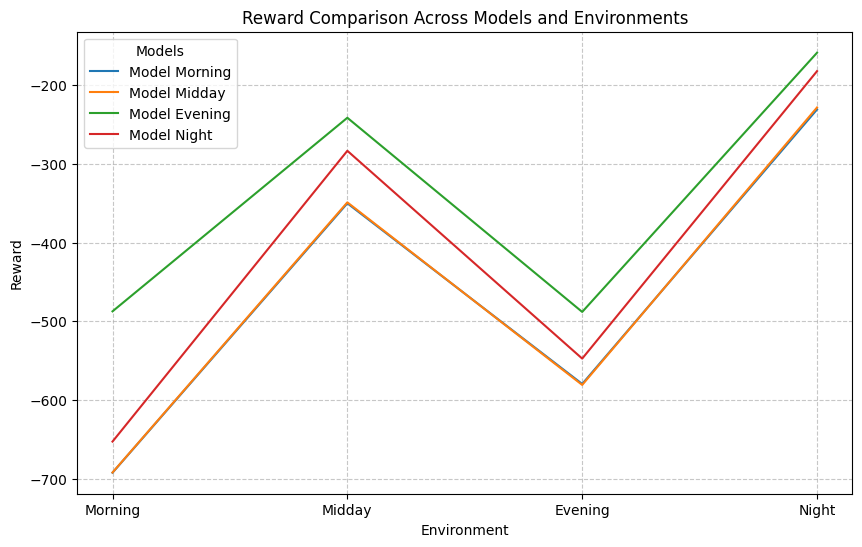

In [47]:
environments = ["Morning", "Midday", "Evening", "Night"]

# Plotting the rewards
plt.figure(figsize=(10, 6))

for i, model_rewards in enumerate(all_rew_table):
    plt.plot(environments, model_rewards, label=f"Model {environments[i]}")

plt.title("Reward Comparison Across Models and Environments")
plt.xlabel("Environment")
plt.ylabel("Reward")
plt.legend(title="Models")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [ ]:
from torch import nn
import torch.nn.functional as F

In [57]:
class WeightedMOE(nn.Module):
    def __init__(self, context_size,  num_expert, experts, device=torch.device('cpu')):
        super().__init__()
        self.gating_network = nn.Sequential(
            nn.Linear(context_size, 128),
            nn.ReLU(),
            nn.Linear(128, num_expert)
        ).to(device)
        self.experts = [DQN.load(path) for prob, path in experts.items()]
        self.device = device

    def forward(self, context:Context):
        """_summary_

        Args:
            context (_type_): _description_
            obs (_type_): _description_

        Returns:
            _type_: _description_
        """
        ctx = torch.tensor(list(context.reward_weights().values())).view(1, -1).to(self.device)
        return F.softmax(self.gating_network(ctx), dim=-1)
    
    def get_expert(self, context):
        with torch.no_grad():
            exp_idx = self.forward(context).argmax().item()
        return self.experts[exp_idx]

    def predict(self, context, obs):
        exp_idx = self.forward(context).argmax().item()
        return self.experts[exp_idx].predict(obs)

In [62]:
experts = {}
wmoe = WeightedMOE(4, 4, experts, torch.device('mps'))
wmoe.experts = [model_morning, model_midday, model_evening, model_night]

In [63]:
optim = torch.optim.SGD(wmoe.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [64]:
loss_log = []
rew_log = []
for epoch in range(10):
    for senv, ctx in zip(
        [sumo_env_morning, sumo_env_midday, sumo_env_evening, sumo_env_night],
        [context_morning, ctx_midday, ctx_evening, ctx_night]
    ):
        obs, info = senv.reset()
        cum_reward = 0
        for _ in range(100):
            expert_prob = wmoe(ctx)
            exp_rew = []
            for mdl in {model_morning, model_midday, model_evening, model_night}:
                rew, _ = eval_DQN(model=mdl, sumo_env=senv, max_iter=100)
                exp_rew.append(rew)
            exp_rew = F.softmax(torch.tensor(exp_rew).view(1, -1), dim=-1).to(torch.device('mps'))
            optim.zero_grad()
            loss = criterion(expert_prob, exp_rew)
            loss.backward()
            optim.step()
            with torch.no_grad():
                action, meta = wmoe.predict(ctx, torch.from_numpy(obs))
            obs, reward, done, trunc, info = senv.step(action)
            if done:
                break
            loss_log.append(loss.item())
            rew_log.append(reward)
            cum_reward += reward
        print(f'training epoch{epoch} context {ctx.name} reward {cum_reward} moe loss {loss.item()}')

Step #500.00 (0ms ?*RT. ?UPS, TraCI: 27318ms, vehicles TOT 541 ACT 141 BUF 468)           
 Retrying in 1 seconds
Step #0.00 (0ms ?*RT. ?UPS, TraCI: 16ms, vehicles TOT 0 ACT 0 BUF 0)                     
 Retrying in 1 seconds
Step #500.00 (0ms ?*RT. ?UPS, TraCI: 37ms, vehicles TOT 278 ACT 122 BUF 731)              
 Retrying in 1 seconds
Step #500.00 (0ms ?*RT. ?UPS, TraCI: 38ms, vehicles TOT 459 ACT 130 BUF 550)              
 Retrying in 1 seconds
Step #500.00 (0ms ?*RT. ?UPS, TraCI: 29ms, vehicles TOT 415 ACT 97 BUF 594)               
 Retrying in 1 seconds
Step #505.00 (0ms ?*RT. ?UPS, TraCI: 52ms, vehicles TOT 550 ACT 127 BUF 469)              
 Retrying in 1 seconds
Step #500.00 (0ms ?*RT. ?UPS, TraCI: 36ms, vehicles TOT 279 ACT 122 BUF 730)              
 Retrying in 1 seconds
Step #500.00 (0ms ?*RT. ?UPS, TraCI: 37ms, vehicles TOT 457 ACT 128 BUF 552)              
 Retrying in 1 seconds
Step #500.00 (1ms ~= 1000.00*RT, ~98000.00UPS, TraCI: 28ms, vehicles TOT 413 ACT 98 BUF 5

KeyboardInterrupt: 

In [73]:
ctx_morning_rainy, sumo_env_morning_rainy = make_context_env(['morning', 'rainy'])

 Retrying in 1 seconds
Step #0.00 (0ms ?*RT. ?UPS, TraCI: 12ms, vehicles TOT 0 ACT 0 BUF 0)                     


In [75]:
model_morning_rainy = train_DQN(sumo_env_morning_rainy, ctx_morning_rainy)

 Retrying in 1 seconds
Using mps device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Step #505.00 (0ms ?*RT. ?UPS, TraCI: 5276204ms, vehicles TOT 533 ACT 140 BUF 486)         
 Retrying in 1 seconds
Step #1000.00 (1ms ~= 1000.00*RT, ~100000.00UPS, TraCI: 30ms, vehicles TOT 777 ACT 100 BUF 
 Retrying in 1 seconds
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 31ms, vehicles TOT 768 ACT 101 BUF 1246)             
 Retrying in 1 seconds
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 31ms, vehicles TOT 756 ACT 104 BUF 1258)             
 Retrying in 1 seconds
Step #1000.00 (0ms ?*RT. ?UPS, TraCI: 31ms, vehicles TOT 777 ACT 101 BUF 1237)             
 Retrying in 1 seconds
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | -102     |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 23       |
|    time_elapsed     | 34   

In [74]:
wmoe(ctx_morning_rainy)

tensor([[0.2310, 0.2245, 0.3988, 0.1456]], device='mps:0',
       grad_fn=<SoftmaxBackward0>)

In [76]:
eval_DQN(sumo_env_morning_rainy, model_morning_rainy)

Step #0.00 (0ms ?*RT. ?UPS, TraCI: 570332ms, vehicles TOT 0 ACT 0 BUF 0)                 
 Retrying in 1 seconds


(-22.799999999999965,
 [{'step': 5.0,
   'system_total_stopped': 0,
   'system_total_waiting_time': 0.0,
   'system_mean_waiting_time': 0.0,
   'system_mean_speed': 11.82342578522281,
   't_stopped': 0,
   't_accumulated_waiting_time': 0.0,
   't_average_speed': 0.8599822624742179,
   'agents_total_stopped': 0,
   'agents_total_accumulated_waiting_time': 0.0},
  {'step': 10.0,
   'system_total_stopped': 0,
   'system_total_waiting_time': 0.0,
   'system_mean_waiting_time': 0.0,
   'system_mean_speed': 11.8600653147047,
   't_stopped': 0,
   't_accumulated_waiting_time': 0.0,
   't_average_speed': 0.8934363519278133,
   'agents_total_stopped': 0,
   'agents_total_accumulated_waiting_time': 0.0},
  {'step': 15.0,
   'system_total_stopped': 5,
   'system_total_waiting_time': 7.0,
   'system_mean_waiting_time': 0.2916666666666667,
   'system_mean_speed': 7.451513542353934,
   't_stopped': 5,
   't_accumulated_waiting_time': 7.0,
   't_average_speed': 0.5567350724798682,
   'agents_total_st

In [77]:
eval_DQN(sumo_env_morning_rainy, model_evening)

Step #5000.00 (1ms ~= 1000.00*RT, ~120000.00UPS, TraCI: 10876ms, vehicles TOT 1280 ACT 120
 Retrying in 1 seconds


(-15.221399999999987,
 [{'step': 5.0,
   'system_total_stopped': 0,
   'system_total_waiting_time': 0.0,
   'system_mean_waiting_time': 0.0,
   'system_mean_speed': 12.875792609157658,
   't_stopped': 0,
   't_accumulated_waiting_time': 0.0,
   't_average_speed': 0.9198099328242305,
   'agents_total_stopped': 0,
   'agents_total_accumulated_waiting_time': 0.0},
  {'step': 10.0,
   'system_total_stopped': 0,
   'system_total_waiting_time': 0.0,
   'system_mean_waiting_time': 0.0,
   'system_mean_speed': 12.99885753748539,
   't_stopped': 0,
   't_accumulated_waiting_time': 0.0,
   't_average_speed': 0.9467460532904662,
   'agents_total_stopped': 0,
   'agents_total_accumulated_waiting_time': 0.0},
  {'step': 15.0,
   'system_total_stopped': 5,
   'system_total_waiting_time': 6.0,
   'system_mean_waiting_time': 0.25,
   'system_mean_speed': 7.807665308119553,
   't_stopped': 5,
   't_accumulated_waiting_time': 6.0,
   't_average_speed': 0.5343372074932464,
   'agents_total_stopped': 5,
 

In [79]:
_, info_ev_mr = eval_DQN(sumo_env_morning_rainy, model_evening)

Step #5000.00 (0ms ?*RT. ?UPS, TraCI: 112524ms, vehicles TOT 3324 ACT 105 BUF 3348)       
 Retrying in 1 seconds


In [80]:
_, info_mr_mr = eval_DQN(sumo_env_morning_rainy, model_morning_rainy)

Step #5000.00 (1ms ~= 1000.00*RT, ~106000.00UPS, TraCI: 55ms, vehicles TOT 3326 ACT 106 BU
 Retrying in 1 seconds


In [81]:
ev_mr = [inf1['reward'] for inf1 in info_ev_mr]
mr_mr = [inf1['reward'] for inf1 in info_mr_mr]

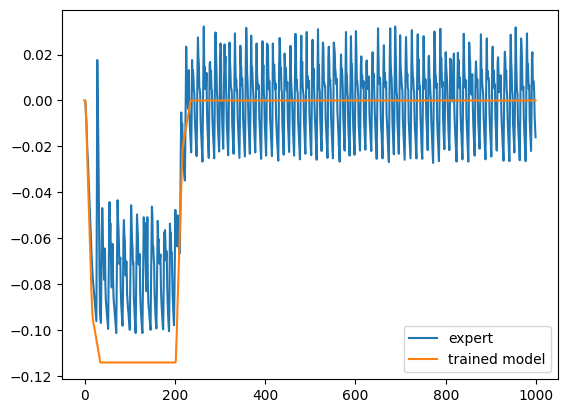

In [84]:
plt.plot(ev_mr, label='expert')
plt.plot(mr_mr, label='trained model')
plt.legend()
plt.show()

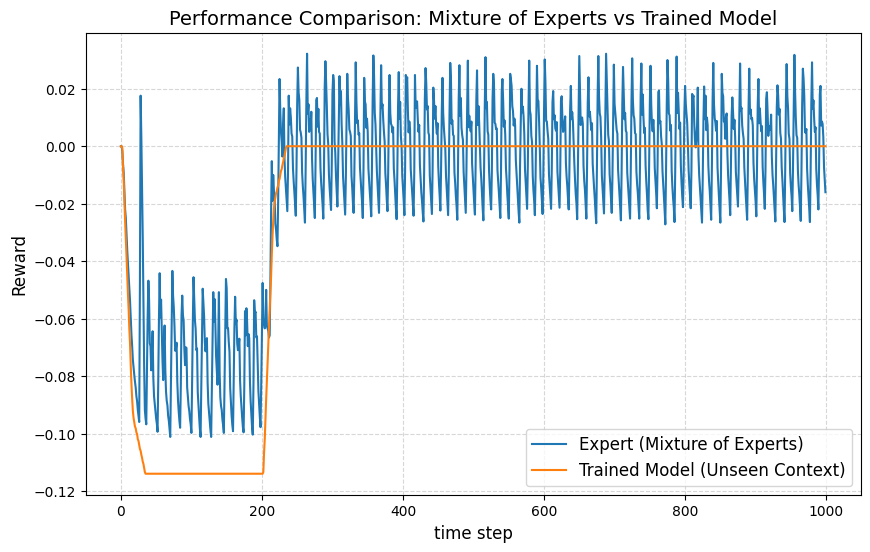

In [86]:
plt.figure(figsize=(10, 6))

# Plot expert and trained model
plt.plot(ev_mr, label='Expert (Mixture of Experts)')
plt.plot(mr_mr, label='Trained Model (Unseen Context)')

# Title and labels
plt.title('Performance Comparison: Mixture of Experts vs Trained Model', fontsize=14)
plt.xlabel('time step', fontsize=12)
plt.ylabel('Reward', fontsize=12)

# Add grid and legend
plt.grid(alpha=0.5, linestyle='--')
plt.legend(fontsize=12, loc='best')

# Show the plot
plt.show()

In [106]:
x = torch.randn(20, 20)*1e-5
y = torch.randn_like(x)*1e-5

In [107]:
xf = torch.fft.fft2(x)
yf = torch.fft.fft2(y)

In [108]:
cmax(xf + yf - torch.fft.fft2(x+y))

(tensor(7.2760e-11), tensor(5.8208e-11))

In [109]:
def cmax(ct):
    return ct.real.max(), ct.imag.max()

In [110]:
cmax(torch.fft.ifft2(xf) + torch.fft.ifft2(yf) - torch.fft.ifft2(xf + yf))

(tensor(5.4570e-12), tensor(2.9264e-12))